# **Switzerland data**

Running this notebook does not require a GPU. You can use a frontal node. However, certain parts such as detecting bounding boxes or removing the background from images require GPUs which are launched in external jobs.

In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from PIL import Image
from pathlib import Path

from lynx_id.utils.preprocess.utils import remove_basename_duplicates, check_filepath, flatten_bbox, get_no_and_multiple_bbox, separate_single_multiple_df, plot_images_conf, absolute_coordinates_bbox
from lynx_id.utils.megadetector.utils import crop_bbox

from idr_pytools import display_slurm_queue, gpu_jobs_submitter, search_log
from megadetector.detection.run_detector_batch import load_and_run_detector_batch, write_results_to_file
from megadetector.utils import path_utils

os.environ['WANDB_DISABLED'] = 'true'  # for megadetector

pd.set_option('display.max_colwidth', None)

In [3]:
# GPU parameters for jobs to be launched (MegaDetector + SAM)
MODULE = 'pytorch-gpu/py3/2.2.0'
account = 'ads@v100'

In [4]:
DATASET = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/")
COUNTRY = "swiss"
SWISS_DATASET_PATH = DATASET / "swiss/Luchs_DB"
NO_BACKGROUND = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/no_background_new")

---

## **Get images (filepath + lynx_id)**

In [5]:
dataset_dict = {
    "filepath": [],
    "lynx_id": [],
}

cnt_img = 0
cnt_img_split = 0
cnt_img_dead = 0
cnt_ignore_keywords_absolute_filepath = 0
cnt_ignore_lynx_ids = 0
cnt_doubt_lynx_ids = 0

all_files = []
ignore_keywords_absolute_filepath = ['renard', 'chat sauvage', 'chat domestique', 'wildschwein', 'marder', 'chamois rupricapra rupicapra', 'martre', 'Autres espèces', 'domestic cat', 'france', 'wolf_', '6 KOMP VI 90 Jahre/Nachweise_VI_90/B405_B406_Petit_Chalet_Neuf_14_04_2014_2144_re_li.JPG', '6 KOMP VI 90 Jahre/Nachweise_VI_90/B205_R114_Kiental_29_07_2009_2206_re.JPG', '6 KOMP VI 90 Jahre/Nachweise_VI_90/B205_B204_Kiental_29_07_2009_2155_re.JPG', '6 KOMP VI 90 Jahre/FIE 2017_18_IVa_SimmeSaane/B379_B677_s14_15_04_2018_0600_re.JPG']
ignore_lynx_ids = ['wildkatze', 'hirsch', 'fuchs', 'XXXX', 'wilkatze', '20080207', 'chat', 'cerf', 'sanglier', 'padding', 'l116', 'lynx lynx lynx b116', 'lynx lynx lynx b122', 'lynx lynx lynx r88', 'lynx lynx lynx wero', 'carvevt', 'nerovorschess', 'garçon']

for current_directory, _, files in os.walk(SWISS_DATASET_PATH):
    for file in files:
        absolute_path = Path(os.path.abspath(os.path.join(current_directory, file)))
        
        # check that the current file is an image
        if re.compile(r'\.(jpg|jpeg|png)$', re.IGNORECASE).search(absolute_path.suffix):
            cnt_img += 1

            absolute_path_relative = absolute_path.relative_to(SWISS_DATASET_PATH)
            absolute_path_parts = absolute_path_relative.parts  # split each element of the path separated by /

            if "_" in file:
                lynx_id = file.split("_")[0].lower().strip()
                if 'färmel' in lynx_id:
                    lynx_id = 'b04'
                if not any(sub.lower() in lynx_id for sub in ["U", "IMG", "Lx", "lx", "CDY"]):
                    cnt_img_split += 1

                    absolute_path_lower = str(absolute_path).lower()

                    # avoid ignore_keywords_absolute_filepath
                    if any(keyword.lower() in absolute_path_lower for keyword in ignore_keywords_absolute_filepath):
                        cnt_img_split -= 1
                        cnt_ignore_keywords_absolute_filepath += 1
                    elif any(keyword.lower() in lynx_id.lower() for keyword in ignore_lynx_ids):
                        cnt_img_split -= 1
                        cnt_ignore_lynx_ids += 1
                    elif lynx_id == "lynx":
                        cnt_img_split -= 1
                        cnt_ignore_lynx_ids += 1
                    elif lynx_id == "b":
                        cnt_img_split -= 1
                        cnt_ignore_lynx_ids += 1
                    elif lynx_id == "katze":
                        cnt_img_split -= 1
                        cnt_ignore_lynx_ids += 1
                    # avoid dead lynx
                    elif 'tot' in absolute_path_parts[1].lower():
                        cnt_img_dead += 1
                        cnt_img_split -= 1
                    elif re.search(r'\(Wild\)katze', str(absolute_path), re.IGNORECASE):
                        cnt_img_split -= 1
                    elif re.search('/Wildkatze/', str(absolute_path), re.IGNORECASE):
                        cnt_img_split -= 1
                    else:
                        dataset_dict["filepath"].append(str(absolute_path))
                        dataset_dict["lynx_id"].append(lynx_id)
                        all_files.append(file)

print(f"Total number of images in the Swiss dataset: {cnt_img}")
print(f"Total number of images with split preprocessing: {cnt_img_split}")
print(f"Number of images of dead lynx: {cnt_img_dead}")
print(f"{cnt_ignore_keywords_absolute_filepath=}")
print(f"{cnt_ignore_lynx_ids=}")

Total number of images in the Swiss dataset: 42137
Total number of images with split preprocessing: 28510
Number of images of dead lynx: 700
cnt_ignore_keywords_absolute_filepath=203
cnt_ignore_lynx_ids=199


In [6]:
df_country = pd.DataFrame(dataset_dict)
df_country

,filepath,lynx_id
0,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/B1009_Cruares_29_03_2022_0530_re_02.JPG,b1009
1,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/L226_Mozza_11_11_2015_li3.JPG,l226
2,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/B280_Turrenberg_19_03_2012_0225_li.JPG,b280
3,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/L226_Mozza_11_11_2015_li2.JPG,l226
4,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/R415_Vignarengo_2022_01_14_0104_re.jpg,r415
...,...,...
28505,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B397_s1b_13_04_2014_2123_li.JPG,b397
28506,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B395_s32_24_02_2014_0459_re.JPG,b395
28507,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B397_s3_03_03_2014_2205_re.JPG,b397
28508,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B398_s5_01_03_2014_2345_xx.JPG,b398


In [7]:
df_country.nunique()

filepath    28510
lynx_id      1697
dtype: int64

### **Handle duplicates**

For Swiss images, we delete images whose file name appears more than once in the dataset. Only one is kept.

In [8]:
df_country = remove_basename_duplicates(df_country, keep_first=True)
df_country.shape

(26182, 2)

In [9]:
df_country.nunique()

filepath    26182
lynx_id      1697
dtype: int64

In [10]:
df_country.reset_index(drop=True, inplace=True)

### **Fix lynx_id**

Some potentially problematic lynx_ids have a space in their name. This often seems to be linked to a naming error.

#### **Space in lynx_id**

In [11]:
indices_to_drop = []

for i, lynx_id in enumerate(df_country.lynx_id.tolist()):
    if re.search(r'\s', lynx_id):
        lynx_id_splitted = lynx_id.split()[0]
        indices_to_drop.append(i)
        if lynx_id_splitted in df_country.lynx_id.tolist():
            print(lynx_id, lynx_id_splitted)
        else:
            print('\t\t\t\t', lynx_id, lynx_id_splitted)

b42 misesspescha b42
b42 valgronda b42
b42 valgronda b42
				 l20 niesen l20
				 b22 oberwil b22
				 b14 imfang b14
				 b26 stantoni b26
				 b14 imfang b14
				 b11 charmey b11
				 l20 niesen l20
				 b26 stantoni b26
				 b22 oberwil b22
				 l27 charmey l27
				 b22 oberwil b22
				 b11 charmey b11
				 b26 stantoni b26
				 b11 charmey b11
				 b14 imfang b14
b59 021015 b59
b44 balzenberg b44
b59 021015 b59
b29 rohrmoos b29
b29 rohrmoos b29
				 b14 imfang b14
m37 niesen 01 m37
zico boltigen 01 zico
				 b14 imfang b14
m37 niesen m37
m37 niesen m37
b29 rohrmoos b29
				 b11 charmey b11
m37 niesen m37
b44 balzenberg b44
b29 rohrmoos b29
				 r23 riegelsee r23
b44 balzenberg b44
				 l27 charmey l27
				 b11 charmey b11
b44 balzenberg b44
b31 lenk b31
m37 niesen m37
				 l27 charmey l27
				 l20 niesen l20
b44 balzenberg b44
b44 balzenberg b44
b29 rohrmoos b29
				 b14 imfang b14
				 kopie von b151 kopie
b59 021015 b59
				 b14 imfang b14
				 b11 charmey b11
				 b26 stantoni b

In [12]:
len(indices_to_drop)

152

This represents a relatively small number of lines. They can be deleted.

In [13]:
df_country = df_country.drop(indices_to_drop)
df_country.shape

(26030, 2)

In [14]:
df_country.nunique()['lynx_id']

1659

#### **ok{lynx_id}**

In [15]:
set(df_country[df_country['lynx_id'].str.contains('^ok', case=False, na=False)].lynx_id)

{'okb112',
 'okb112li',
 'okb88',
 'okl110',
 'okl111',
 'oknoia',
 'okr100',
 'okr101',
 'okwero'}

In [16]:
df_country['lynx_id'] = df_country['lynx_id'].apply(lambda x: x[2:] if x.lower().startswith('ok') else x)
df_country.shape

(26030, 2)

In [17]:
df_country.nunique()['lynx_id']

1650

#### **^[a-zA-Z]{2,}\d+**

In [18]:
df_country = df_country[~df_country['lynx_id'].str.contains('^[a-zA-Z]{2,}\d+', case=False, na=False)]
df_country.shape

(25896, 2)

#### **^[rlb]\d+[a-zA-Z]+**

In [19]:
mask = df_country['lynx_id'].str.contains('^[rlb]\d+[a-zA-Z]+', case=False, na=False)
df_country.loc[mask, 'lynx_id'] = df_country.loc[mask, 'lynx_id'].str.extract(r'^([rlb]\d+)', expand=False)
df_country.shape

(25896, 2)

#### **Exclude rows with - in lynx_id**

In [20]:
df_country = df_country[~df_country['lynx_id'].str.contains('-', case=False, na=False)]

**Note: I think that individuals b{number}, l{number}, r{number} are different.**
You might think that they are the same individual for the same number with photos taken on the left, right or both sides (doubt). After checking some individuals, it seems that they are not the same individuals. Example of invidivus: 275, 379.

In [21]:
df_country.shape

(25861, 2)

### **[rlb]{number} == same lynx_id**

In [22]:
mask = df_country['lynx_id'].str.match(r'^[rbl]\d+$')
df_country.loc[mask, 'lynx_id'] = df_country.loc[mask, 'lynx_id'].str[1:]

In [23]:
df_country.nunique()

filepath    25861
lynx_id      1148
dtype: int64

In [24]:
print(sorted(set(df_country.lynx_id.tolist())))

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '101', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '102', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '103', '1030', '1031', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '19

In [25]:
df_country.reset_index(drop=True, inplace=True)

### **Deleting broken images**

In [26]:
all_files_exist = all(df_country['filepath'].apply(os.path.exists))
all_files_exist

True

## **Bounding box detection**

In [27]:
country_output_megadetector = DATASET / COUNTRY / f"bbox_{COUNTRY}.json"  # WARNING: change filename if needed
country_output_megadetector

PosixPath('/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/bbox_swiss.json')

In [28]:
image_filenames = df_country['filepath'].tolist()
len(image_filenames)

25861

In [29]:
display_slurm_queue(name=f"megadetector_{COUNTRY}", timestep=60)


 Done!


In [30]:
with open(country_output_megadetector, 'r') as f:
    bbox_country = json.load(f)

Some images may not have bounding boxes found.

In [31]:
no_bbox_country, multiple_bbox_country = get_no_and_multiple_bbox(bbox_country)

813 images have no bounding boxes detected.
2934 images have several bounding boxes detected.
Total: 28932 images.


Absolute coordinates of the bounding box (x, y, width and height) based on the image dimensions

In [32]:
df_bbox_country = flatten_bbox(bbox_country, add_image_without_bbox=False, verbose=False)
df_bbox_country = absolute_coordinates_bbox(df_bbox_country)

df_bbox_country

,file,im_width,im_height,category,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/B1009_Cruares_29_03_2022_0530_re_02.JPG,2048,1365,1,0.958,1480.9088,535.8990,324.8128,273.9555
1,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/L226_Mozza_11_11_2015_li3.JPG,1200,1600,1,0.622,0.0000,390.8800,801.0000,706.8800
2,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/L226_Mozza_11_11_2015_li2.JPG,1200,1600,1,0.602,660.9600,242.8800,538.9200,766.8800
3,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/R415_Vignarengo_2022_01_14_0104_re.jpg,1920,1072,1,0.535,1685.9520,867.9984,233.8560,201.9648
4,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/R415_Vignarengo_2022_01_14_0104_re.jpg,1920,1072,1,0.872,298.9440,460.9600,234.8160,161.9792
...,...,...,...,...,...,...,...,...,...
31472,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B395_s32_14_02_2014_2146_li.JPG,2048,1536,1,0.963,105.9840,307.9680,1065.9840,686.8992
31473,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B397_s1b_13_04_2014_2123_li.JPG,2592,2000,1,0.956,827.8848,924.0000,401.7600,305.8000
31474,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B395_s32_24_02_2014_0459_re.JPG,2048,1536,1,0.970,630.9888,261.8880,1085.8496,641.8944
31475,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B397_s3_03_03_2014_2205_re.JPG,2048,1536,1,0.976,336.8960,235.9296,972.8000,896.8704


In [33]:
df_bbox_country.nunique()['file']

28119

### **10 images cropped with the least confidence are displayed**

Only images with a single bounding box are displayed.

In [34]:
df_bbox_country_single_detection, df_bbox_country_multiple_detections = separate_single_multiple_df(df_bbox_country)

print(len(df_bbox_country_single_detection))
print(len(df_bbox_country_multiple_detections))

25185
6292


In [35]:
%matplotlib inline

In [36]:
df_bbox_country_single_detection

,file,im_width,im_height,category,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/B1009_Cruares_29_03_2022_0530_re_02.JPG,2048,1365,1,0.958,1480.9088,535.8990,324.8128,273.9555
1,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/L226_Mozza_11_11_2015_li3.JPG,1200,1600,1,0.622,0.0000,390.8800,801.0000,706.8800
2,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/L226_Mozza_11_11_2015_li2.JPG,1200,1600,1,0.602,660.9600,242.8800,538.9200,766.8800
3,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/L226_Mozza_11_11_2015_re.JPG,1200,1600,1,0.744,548.8800,348.9600,225.0000,481.9200
4,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/B1009_Cruares_29_03_2022_0530_li.JPG,2048,1365,1,0.938,726.8352,734.9160,388.9152,215.9430
...,...,...,...,...,...,...,...,...,...
25180,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B395_s32_14_02_2014_2146_li.JPG,2048,1536,1,0.963,105.9840,307.9680,1065.9840,686.8992
25181,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B397_s1b_13_04_2014_2123_li.JPG,2592,2000,1,0.956,827.8848,924.0000,401.7600,305.8000
25182,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B395_s32_24_02_2014_0459_re.JPG,2048,1536,1,0.970,630.9888,261.8880,1085.8496,641.8944
25183,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B397_s3_03_03_2014_2205_re.JPG,2048,1536,1,0.976,336.8960,235.9296,972.8000,896.8704


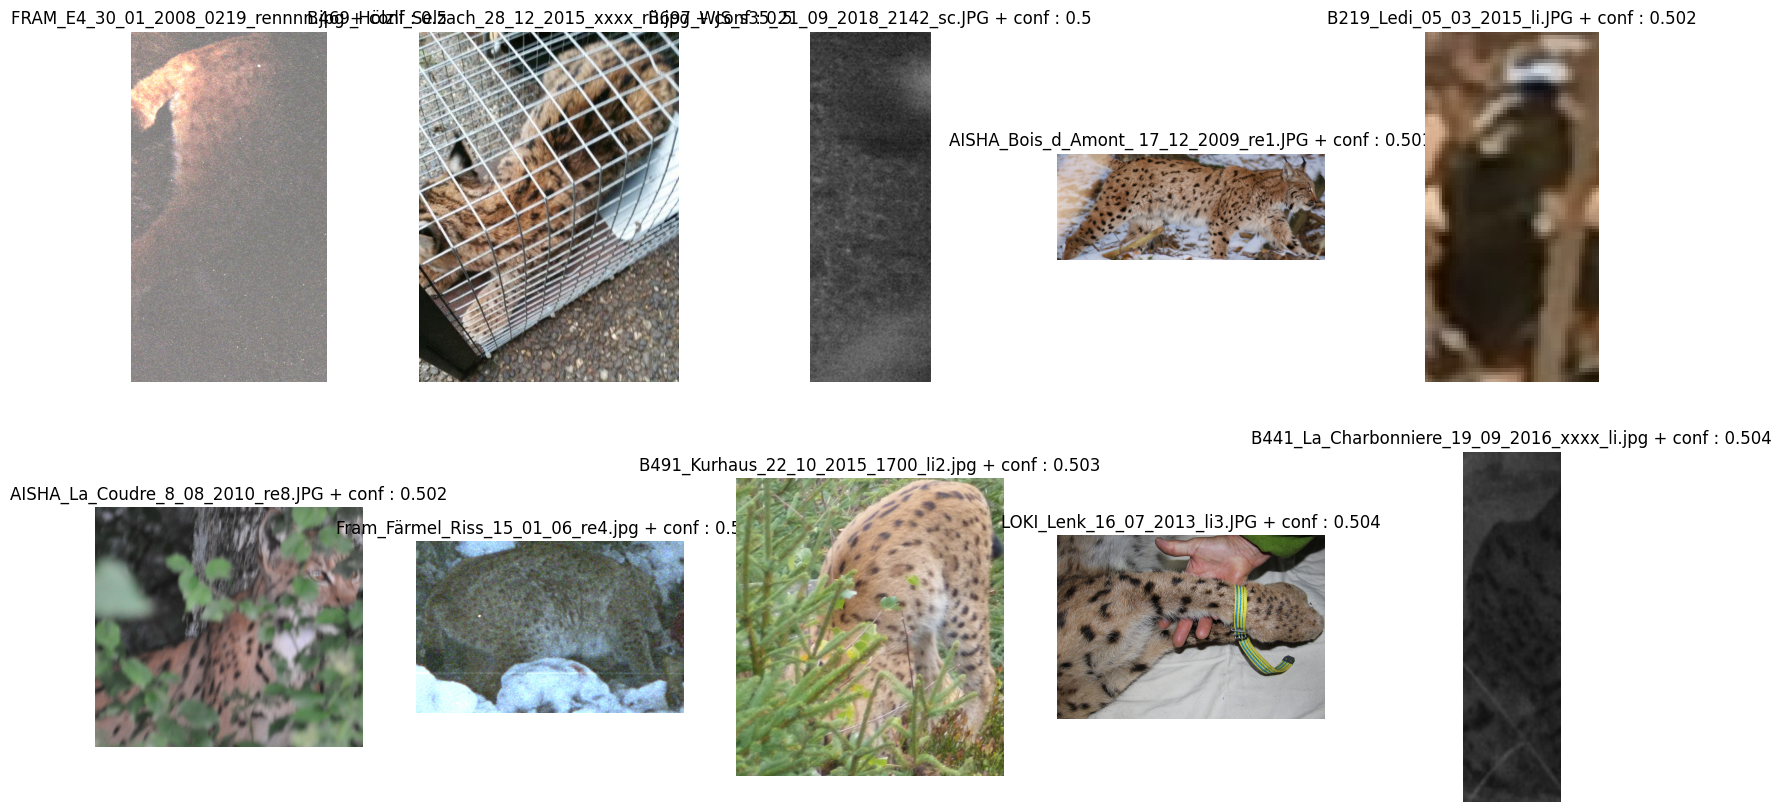

In [37]:
plot_images_conf(df_bbox_country_single_detection, by="smallest")

### **10 images cropped with the largest confidence are displayed**

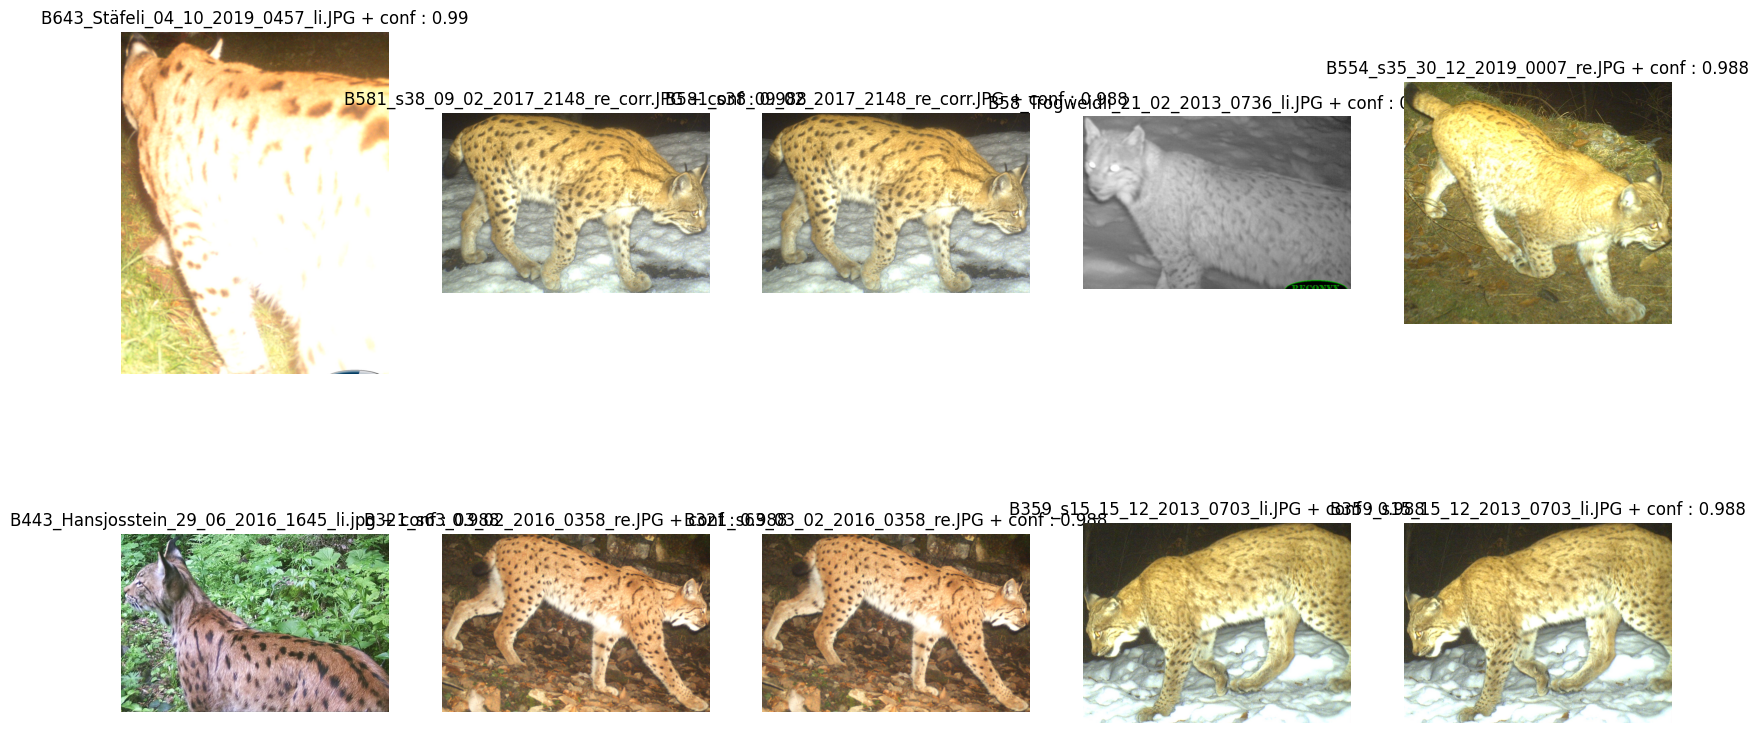

In [38]:
plot_images_conf(df_bbox_country_single_detection, by="largest")

In [39]:
df_country_with_bbox = pd.merge(df_country, df_bbox_country_single_detection[['file', 'conf', 'x', 'y', 'width', 'height']], how='inner', left_on='filepath', right_on='file')
df_country_with_bbox = df_country_with_bbox.drop('file', axis=1)

df_country_with_bbox

,filepath,lynx_id,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/B1009_Cruares_29_03_2022_0530_re_02.JPG,1009,0.958,1480.9088,535.8990,324.8128,273.9555
1,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/L226_Mozza_11_11_2015_li3.JPG,226,0.622,0.0000,390.8800,801.0000,706.8800
2,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/L226_Mozza_11_11_2015_li2.JPG,226,0.602,660.9600,242.8800,538.9200,766.8800
3,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/L226_Mozza_11_11_2015_re.JPG,226,0.744,548.8800,348.9600,225.0000,481.9200
4,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/B1009_Cruares_29_03_2022_0530_li.JPG,1009,0.938,726.8352,734.9160,388.9152,215.9430
...,...,...,...,...,...,...,...
22399,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B395_s32_14_02_2014_2146_li.JPG,395,0.963,105.9840,307.9680,1065.9840,686.8992
22400,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B397_s1b_13_04_2014_2123_li.JPG,397,0.956,827.8848,924.0000,401.7600,305.8000
22401,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B395_s32_24_02_2014_0459_re.JPG,395,0.970,630.9888,261.8880,1085.8496,641.8944
22402,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B397_s3_03_03_2014_2205_re.JPG,397,0.976,336.8960,235.9296,972.8000,896.8704


#### Bounding box confidence distribution

<Axes: xlabel='conf', ylabel='Count'>

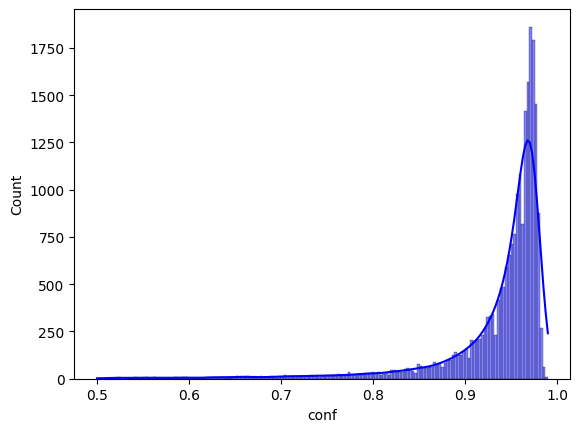

In [40]:
import seaborn as sns

sns.histplot(df_country_with_bbox["conf"], kde=True, color='blue')

## **Compute `image_number` for each individual**

This number is no longer the same as initially following filtering, particularly of images with no bounding box detected, for example.

In [41]:
df_country_with_bbox['image_number'] = df_country_with_bbox.groupby('lynx_id').cumcount() + 1
df_country_with_bbox

,filepath,lynx_id,conf,x,y,width,height,image_number
0,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/B1009_Cruares_29_03_2022_0530_re_02.JPG,1009,0.958,1480.9088,535.8990,324.8128,273.9555,1
1,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/L226_Mozza_11_11_2015_li3.JPG,226,0.622,0.0000,390.8800,801.0000,706.8800,1
2,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/L226_Mozza_11_11_2015_li2.JPG,226,0.602,660.9600,242.8800,538.9200,766.8800,2
3,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/L226_Mozza_11_11_2015_re.JPG,226,0.744,548.8800,348.9600,225.0000,481.9200,3
4,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/B1009_Cruares_29_03_2022_0530_li.JPG,1009,0.938,726.8352,734.9160,388.9152,215.9430,2
...,...,...,...,...,...,...,...,...
22399,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B395_s32_14_02_2014_2146_li.JPG,395,0.963,105.9840,307.9680,1065.9840,686.8992,66
22400,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B397_s1b_13_04_2014_2123_li.JPG,397,0.956,827.8848,924.0000,401.7600,305.8000,81
22401,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B395_s32_24_02_2014_0459_re.JPG,395,0.970,630.9888,261.8880,1085.8496,641.8944,67
22402,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/7 KOMP VII/FIE 2014/Capture/B397_s3_03_03_2014_2205_re.JPG,397,0.976,336.8960,235.9296,972.8000,896.8704,82


## **Add other information**

In [42]:
needed_columns = ['source', 'pattern', 'date', 'location']
for col in needed_columns:
    if col not in df_country_with_bbox.columns:
        df_country_with_bbox[col] = np.nan

In [43]:
df_country_with_bbox['country'] = COUNTRY

In [44]:
df_country_with_bbox.to_csv(DATASET / COUNTRY / f"lynx_dataset_{COUNTRY}.csv", index=False)

## **Remove backgrounds**

Images without backgrounds are calculated using the `Segment Anything Model`. These are saved here: `/gpfsscratch/rech/ads/commun/datasets/extracted/no_background`.  
The csv file is completed with a `filepath_no_bg` column and saved here: `/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full_no_bg.csv`

In [45]:
df_country_with_bbox = pd.read_csv(DATASET / f"{COUNTRY}" / f"lynx_dataset_{COUNTRY}.csv")

In [46]:
df_country_with_bbox.head()

,filepath,lynx_id,conf,x,y,width,height,image_number,source,pattern,date,location,country
0,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/B1009_Cruares_29_03_2022_0530_re_02.JPG,1009,0.958,1480.9088,535.899,324.8128,273.9555,1,NaN,NaN,NaN,NaN,swiss
1,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/L226_Mozza_11_11_2015_li3.JPG,226,0.622,0.0000,390.880,801.0000,706.8800,1,NaN,NaN,NaN,NaN,swiss
2,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/L226_Mozza_11_11_2015_li2.JPG,226,0.602,660.9600,242.880,538.9200,766.8800,2,NaN,NaN,NaN,NaN,swiss
3,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/L226_Mozza_11_11_2015_re.JPG,226,0.744,548.8800,348.960,225.0000,481.9200,3,NaN,NaN,NaN,NaN,swiss
4,/gpfsscratch/rech/ads/commun/datasets/extracted/swiss/Luchs_DB/8 KOMP VIII/Nachweise VIII/B1009_Cruares_29_03_2022_0530_li.JPG,1009,0.938,726.8352,734.916,388.9152,215.9430,2,NaN,NaN,NaN,NaN,swiss


### **Add the `filepath_no_bg` column based on existing images**

In [47]:
df_country_with_bbox['filepath_no_bg'] = df_country_with_bbox.apply(lambda row: check_filepath(NO_BACKGROUND, COUNTRY, row['filepath'], row['lynx_id'], row['image_number']), axis=1)

In [48]:
row = df_country_with_bbox.iloc[3]
lynx_id = row['lynx_id'].lower()
image_number = row['image_number']
filepath = row['filepath']

NO_BACKGROUND / COUNTRY / lynx_id / Path(f"no_bg_{image_number}_{os.path.basename(filepath)}")

PosixPath('/gpfsscratch/rech/ads/commun/datasets/extracted/no_background_new/swiss/226/no_bg_3_L226_Mozza_11_11_2015_re.JPG')

In [49]:
print(f"Number of images remaining to be calculated: {df_country_with_bbox['filepath_no_bg'].isna().sum()}")

Number of images remaining to be calculated: 22404


In [50]:
df_country_with_bbox.to_csv(DATASET / COUNTRY / f"lynx_dataset_{COUNTRY}.csv", index=False)

In [51]:
n_gpu = 1
csv_file = f"/gpfsscratch/rech/ads/commun/datasets/extracted/{COUNTRY}/lynx_dataset_{COUNTRY}.csv"
save_img_directory = NO_BACKGROUND
command = f'remove_background.py --csv_file {csv_file} --save_img_directory {save_img_directory} --skip_already_computed'

jobid = gpu_jobs_submitter(command, n_gpu, MODULE, name=f'sam_{COUNTRY}', account=account, time_max='08:00:00')
print(f'jobid = {jobid}')

batch job 0: 1 GPUs distributed on 1 nodes with 1 tasks / 1 gpus per node and 10 cpus per task
Submitted batch job 624687
jobid = ['624687']


In [ ]:
display_slurm_queue(name=f'sam_{COUNTRY}', timestep=60)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            624687   gpu_p13 sam_swis  uxp55sd PD       0:00      1 (None)


In [ ]:
df_full = pd.read_csv(DATASET / f"{COUNTRY}" / f"lynx_dataset_{COUNTRY}.csv")

In [ ]:
df_full.groupby('country').nunique()[['filepath', 'filepath_no_bg']]

In [ ]:
all_files_exist = df_full['filepath_no_bg'].apply(lambda x: pd.isna(x) or os.path.exists(x)).all()
assert all_files_exist